In [1]:
from generate_data import Data
from evaluate import *
from models import *

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
%autosave 120

Autosaving every 120 seconds


# Get the synthetic dataset

In [3]:
%%time
data = Data(layer_size=16, interop_distances=[0,1,2])

C:\Users\Luna Santos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


CPU times: total: 4.75 s
Wall time: 5.23 s


In [4]:
%%time
train, val, test = data.get_splits(['omit_distances', 'random_subsample'], [[1], [0.25, 0.75]])

train_unshuffled = train.copy()
np.random.shuffle(train)

x_train, y_train = data.get_x_y(train)
x_val, y_val = data.get_x_y(val)
x_test, y_test = data.get_x_y(test)

train_original = data.reverse_encoding(data.get_x_y(train_unshuffled)[0])
val_original = data.reverse_encoding(x_val)
test_original = data.reverse_encoding(x_test)

Number of samples: 1988 train | 941 val | 3765 test
CPU times: total: 5min 31s
Wall time: 6min 8s


#### Peek at unshuffled train data

In [6]:
train_original[:20]

[['.._,,_,,_,,___,.', ',w._u,_,_..._,._', '_,_,._.c,_r..._,', False],
 [',.,______.___.__', ',_,.,_,_,,..._.,', ',..,_,...,,.,_..', False],
 ['____._,.,_.,_,_,', '_._...wu,,.,.,,_', ',,,r.._,_...__._', True],
 ['_,._._..,..__.,,', ',,,..,,,,_,.._w.', '.,..,.,.,.._,...', False],
 [',___._.,..___,,,', '.._,_____..w,.u_', '.._.._.._._,,.,,', False],
 [',.,,.,_.,___.,,_', ',__w,..__,.,..._', '__._,._._d_.r,,.', True],
 ['_,.._..,,._.,,_,', ',u,_w,,_.__.._,_', '.,.,__,.,.__._,_', False],
 ['.._.._.__.,,.,_,', '.____._.,.uw_,..', ',,,.,_,.,,_.....', False],
 ['.,,__,,_,,__,.._', '_.,__,__.,,,_,_.', '._.._,.,_,_.cr..', False],
 ['.,,_,_,,_,_.._,_', '.___uw____,..,,,', '._.._.._.._dr,,,', True],
 ['...__.,..__._.._', '.....,_.,_,w_._,', ',..._.,_,,.cr,_,', False],
 ['_..,....__.__,.,', '.wu,..,,,._.,..,', '._.____,.,_.__,_', False],
 [',..,_.___,_..,,.', '...__,wu_.._..__', '_.,,._...,..,._,', False],
 ['.__,_,,.._.,._.,', '_.___._..,_.w._u', '...,.,,..c_.r,._', False],
 ['..._,__,.,,.,.__', '

In [7]:
pos_train_ratio = get_stats_and_ratio(train_original)

Number of samples by case:
F3 dr:    F2-wu 88 | F2-uw 115 | F2-w 123 | F2-noop 120 | 
F3 cr:    F2-wu 102 | F2-uw 79 | F2-w 104 | F2-noop 111 | 
F3 r:    F2-wu 100 | F2-uw 113 | F2-w 159 | F2-noop 180 | 
F3 noop:    F2-wu 123 | F2-uw 105 | F2-w 160 | F2-noop 206 | 

Positive samples count: 910
Total samples count: 1988
Positive class ratio: 0.45774647887323944


#### Peek at test data

In [8]:
test_original[:15]

[['__.,,,.,__,,..,,', 'w,u._,,_.,,.._._', '_.c_r,..__,_,.,,', False],
 ['__._,_,.._..,.,_', '__..w_u,.,_.,._.', '..,d,r__..._..__', False],
 [',__.__.,_._,._._', '..,,_,__,.,u.w,.', '_.___,_d.r.._,,.', True],
 ['..,__,.._.,_,.._', '__._..__._..__._', '__._,..__r,_.,_.', True],
 ['.....__,...,.,_,', '_..u,w,,_.,____,', '..,,,,_d,r,_.._.', True],
 [',.,._,.__,,__.,,', '..___._.,.u_w..,', '_..__,_,,,__r_..', True],
 ['.,,._,_,,.,,,_._', '..,_._,,._.,,_..', ',,____,.c.r___,,', False],
 [',__,._,.___._.__', ',,.,__,._,,,_._,', ',.,c_r.,,,,_,__,', False],
 ['.....__,.....__.', '__.w.._,._,._,,.', '..__c,r_,_,_..,.', False],
 [',._,,,,.,_,.,..,', 'w.__,._._.____..', '__,,.,_,r.......', True],
 ['._,.,_,._.._,,_.', ',_.,..,__u_w_..,', '.,_.,_,,_____.,.', False],
 ['__..,,______._.,', ',,.,._w,,_.,.,._', '__,_,.,_.,....,_', False],
 [',__,.__,_,..__,.', '._..,_..u.w,.,_.', ',,,,,_._,_.,,_,.', False],
 [',..,__,,_._,.,,.', 'u_w...___,_.____', ',__,_.,,,_._.,_.', False],
 ['__,,__.,._._,_,_', '_.

In [9]:
pos_test_ratio = get_stats_and_ratio(test_original)

Number of samples by case:
F3 dr:    F2-wu 142 | F2-uw 161 | F2-w 168 | F2-noop 176 | 
F3 cr:    F2-wu 152 | F2-uw 165 | F2-w 171 | F2-noop 178 | 
F3 r:    F2-wu 172 | F2-uw 157 | F2-w 419 | F2-noop 432 | 
F3 noop:    F2-wu 188 | F2-uw 181 | F2-w 452 | F2-noop 451 | 

Positive samples count: 1685
Total samples count: 3765
Positive class ratio: 0.44754316069057104


#### Peek at val data

In [10]:
val_original[:15]

[['_.,__,._.____.,.', '__.w..._.,.,_...', ',_._____,_.,__,.', False],
 ['____.._,.__,_.,,', ',,,.___.___,,,,_', '_,,_,,d,r..,.,__', True],
 [',.,,_,,_,.,__,,.', '._,,.,..._.,..,.', '__._.._,.,_.._,_', False],
 ['.____.,,.,.,,,,,', ',,____._,..,,,,.', '__.,_._,._...r._', True],
 ['.,,.._,,___,.,.,', ',__,.,w.u,,,_..,', '._..____._,_.__,', False],
 ['_,.,_._..._...,,', '_.,,_...w____,..', '_...._..,.,,,..r', True],
 ['.,_.,.__,_..__,,', ',_.,_,_._,,,,.w_', '__.__.__,,.____.', False],
 [',._,._._,....,.,', ',._,_.....__.u_w', 'c_r,,._..,_.,,,.', False],
 ['.,,,,,._,.._,.._', '.u_w._,...._...,', ',,..d,r_,__.,.__', True],
 ['._,,,.,._.__....', '._,,_w_...,.,,__', ',,d.r.___,,_._,.', True],
 [',.,,_,.___......', '_,._,,_,__,,_,_.', '_._d.r,,_,,,_.,,', True],
 [',._,.,.._.___._,', ',__.._._,w.,_.,.', '___,._c,r,,_....', False],
 [',,_,,,_....,,_..', ',.,___u_w___,..,', 'r,._,,_._,._,_,_', True],
 ['__.,.,...,_,.,._', ',_.._.,,,,.,,,,.', '.,__r.,____,_,.,', True],
 ['.,.__._,._.,,,..', '_,,_.

In [11]:
pos_val_ratio = get_stats_and_ratio(val_original)

Number of samples by case:
F3 dr:    F2-wu 54 | F2-uw 35 | F2-w 42 | F2-noop 48 | 
F3 cr:    F2-wu 44 | F2-uw 31 | F2-w 39 | F2-noop 46 | 
F3 r:    F2-wu 38 | F2-uw 53 | F2-w 99 | F2-noop 110 | 
F3 noop:    F2-wu 36 | F2-uw 43 | F2-w 110 | F2-noop 113 | 

Positive samples count: 425
Total samples count: 941
Positive class ratio: 0.45164718384697133


#### Send label arrays to device

In [5]:
y_train = torch.from_numpy(y_train.astype(float)).float().to(device)
y_val = torch.from_numpy(y_val.astype(float)).float().to(device)
y_test = torch.from_numpy(y_test.astype(float)).float().to(device)

#### Get data in normal format (same as CNN format)

In [13]:
x_train_normal = data.to_conv_format(x_train)
x_val_normal = data.to_conv_format(x_val)
x_test_normal = data.to_conv_format(x_test)
for i in range(len(x_train_normal)):
    x_train_normal[i] = x_train_normal[i].to(device)
    x_val_normal[i] = x_val_normal[i].to(device)
    x_test_normal[i] = x_test_normal[i].to(device)

In [14]:
x_train_normal[0].shape

torch.Size([1988, 128])

#### Get data in convolutional format, send to device

In [15]:
x_train_cnn = data.to_conv_format(x_train, padding_left_size=2, padding_right_size=2)
x_val_cnn = data.to_conv_format(x_val, padding_left_size=2, padding_right_size=2)
x_test_cnn = data.to_conv_format(x_test, padding_left_size=2, padding_right_size=2)
for i in range(len(x_train_cnn)):
    x_train_cnn[i] = x_train_cnn[i].to(device)
    x_val_cnn[i] = x_val_cnn[i].to(device)
    x_test_cnn[i] = x_test_cnn[i].to(device)

In [16]:
x_train_cnn[0].shape

torch.Size([1988, 160])

#### Get data in LSTM format, send to device

In [17]:
x_train_lstm = data.to_lstm_format(x_train)
x_val_lstm = data.to_lstm_format(x_val)
x_test_lstm = data.to_lstm_format(x_test)
for i in range(len(x_train_lstm)):
    x_train_lstm[i] = x_train_lstm[i].to(device)
    x_val_lstm[i] = x_val_lstm[i].to(device)
    x_test_lstm[i] = x_test_lstm[i].to(device)

In [18]:
x_train_lstm[0].shape

torch.Size([1988, 16, 8])

### Define training parameters

In [6]:
num_experiments = 20
epochs = 200
early_stopping_limit = 100

experiment_name = "interop_1"

### Define training procedure for each model

In [20]:
def train_models(constructor, x_train, x_val, x_test, weight_decay, *argv):
    accuracies = [] #lista con la precisión de cada modelo en el cjto de prueba
    precisions = []
    recalls = []
    f1_scores = []
    wrong_preds = []#lista con las predicciones incorrectas del modelo en el cjto de prueba
    best_accuracy = 0
    
    #listas de listas de cada modelo durante el entrenamiento y prueba
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for i in range(num_experiments):
        model = constructor(*argv)
        model.to(device)

        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([(1-pos_train_ratio)/pos_train_ratio]).to(device))
        optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay)

        train_losses.append([])
        val_losses.append([])
        train_accs.append([])
        val_accs.append([])
        
        best_acc = 0

        early_stopping_cnt = 0

        for epoch in range(1, epochs + 1):
            train_loss, train_acc = train_epoch(model, x_train, y_train, criterion, optimizer, epoch, 10, verbose=False)
            val_loss, val_acc = eval_epoch(model, x_val, y_val, criterion, 'Validation', verbose=False)

            
            train_losses[-1].append(train_loss)
            val_losses[-1].append(val_loss)
            train_accs[-1].append(train_acc)
            val_accs[-1].append(val_acc)
            
            model_name = constructor.__name__[:constructor.__name__.find('_')]
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), f'./temp/{model_name}_model_TEMP_' + experiment_name)    
                early_stopping_cnt = 0
            else:
                early_stopping_cnt += 1

            if early_stopping_cnt >= early_stopping_limit:
                break

        model.load_state_dict(torch.load(f'./temp/{model_name}_model_TEMP_' + experiment_name))

        accuracies.append(get_accuracy_by_cases(model, x_test, y_test, test_original)) #Se evalúa el modelo en el conjunto de prueba 
        precisions.append(get_precision(model, x_test, y_test, test_original))
        recalls.append(get_recall(model, x_test, y_test, test_original))
        f1_scores.append(get_f1(precisions[-1], recalls[-1]))        
        
        wrong_preds.append(get_wrong_predictions(model, x_test, y_test, test_original))

        if accuracies[-1]['Overall'] > best_accuracy:
            torch.save(model.state_dict(), f'./bestmodels/best_{model_name}_model_' + experiment_name)    
            best_accuracy = accuracies[-1]['Overall']

        print(i + 1, "/", num_experiments, "models trained | Current model best validation accuracy:", best_accuracy)

    return accuracies, precisions, recalls, f1_scores,  wrong_preds, [train_losses, val_losses, train_accs, val_accs]

# Train models

In [21]:
%%time
cnn_accuracies, cnn_precisions, cnn_recall, cnn_f1_scores, cnn_wrong_preds, cnn_epoch_stats = train_models(CNN_Model, x_train_cnn, x_val_cnn, x_test_cnn, 0.005, data, 32, 64, 4, -1, 'keras')


1 / 20 models trained | Current model best validation accuracy: 0.9622841965471447
2 / 20 models trained | Current model best validation accuracy: 0.9622841965471447
3 / 20 models trained | Current model best validation accuracy: 0.9622841965471447
4 / 20 models trained | Current model best validation accuracy: 0.9622841965471447
5 / 20 models trained | Current model best validation accuracy: 0.9622841965471447
6 / 20 models trained | Current model best validation accuracy: 0.9622841965471447
7 / 20 models trained | Current model best validation accuracy: 0.9622841965471447
8 / 20 models trained | Current model best validation accuracy: 0.9622841965471447
9 / 20 models trained | Current model best validation accuracy: 0.9622841965471447
10 / 20 models trained | Current model best validation accuracy: 0.9853917662682603
11 / 20 models trained | Current model best validation accuracy: 0.9853917662682603
12 / 20 models trained | Current model best validation accuracy: 0.9853917662682603
1

In [22]:
%%time
lstm_accuracies, lstm_precisions, lstm_recall, lstm_f1_scores, lstm_wrong_preds, lstm_epoch_stats = train_models(LSTM_Model, x_train_lstm, x_val_lstm, x_test_lstm, 0.0001, data, 16, 32, 8, 'keras')

1 / 20 models trained | Current model best validation accuracy: 0.9601593625498008
2 / 20 models trained | Current model best validation accuracy: 1.0
3 / 20 models trained | Current model best validation accuracy: 1.0
4 / 20 models trained | Current model best validation accuracy: 1.0
5 / 20 models trained | Current model best validation accuracy: 1.0
6 / 20 models trained | Current model best validation accuracy: 1.0
7 / 20 models trained | Current model best validation accuracy: 1.0
8 / 20 models trained | Current model best validation accuracy: 1.0
9 / 20 models trained | Current model best validation accuracy: 1.0
10 / 20 models trained | Current model best validation accuracy: 1.0
11 / 20 models trained | Current model best validation accuracy: 1.0
12 / 20 models trained | Current model best validation accuracy: 1.0
13 / 20 models trained | Current model best validation accuracy: 1.0
14 / 20 models trained | Current model best validation accuracy: 1.0
15 / 20 models trained | Cur

In [23]:
%%time
deepset_accuracies, deepset_precisions, deepset_recall, deepset_f1_scores,deepset_wrong_preds, deepset_epoch_stats = train_models(DEEPSET_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

1 / 20 models trained | Current model best validation accuracy: 0.9543160690571049
2 / 20 models trained | Current model best validation accuracy: 0.9601593625498008
3 / 20 models trained | Current model best validation accuracy: 0.9601593625498008
4 / 20 models trained | Current model best validation accuracy: 0.9601593625498008
5 / 20 models trained | Current model best validation accuracy: 0.9601593625498008
6 / 20 models trained | Current model best validation accuracy: 0.9601593625498008
7 / 20 models trained | Current model best validation accuracy: 0.9601593625498008
8 / 20 models trained | Current model best validation accuracy: 0.9601593625498008
9 / 20 models trained | Current model best validation accuracy: 0.9604249667994688
10 / 20 models trained | Current model best validation accuracy: 0.9604249667994688
11 / 20 models trained | Current model best validation accuracy: 0.9604249667994688
12 / 20 models trained | Current model best validation accuracy: 0.9604249667994688
1

In [24]:
%%time
deepsetv2_accuracies, deepsetv2_precisions, deepsetv2_recall, deepsetv2_f1_scores, deepsetv2_wrong_preds, deepsetv2_epoch_stats = train_models(DEEPSETV2_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 32, 8, 'keras')

1 / 20 models trained | Current model best validation accuracy: 0.44754316069057104
2 / 20 models trained | Current model best validation accuracy: 0.44754316069057104
3 / 20 models trained | Current model best validation accuracy: 0.44754316069057104
4 / 20 models trained | Current model best validation accuracy: 0.44754316069057104
5 / 20 models trained | Current model best validation accuracy: 0.44754316069057104
6 / 20 models trained | Current model best validation accuracy: 0.44754316069057104
7 / 20 models trained | Current model best validation accuracy: 0.44754316069057104
8 / 20 models trained | Current model best validation accuracy: 0.44754316069057104
9 / 20 models trained | Current model best validation accuracy: 0.44754316069057104
10 / 20 models trained | Current model best validation accuracy: 0.44754316069057104
11 / 20 models trained | Current model best validation accuracy: 0.44754316069057104
12 / 20 models trained | Current model best validation accuracy: 0.4475431

In [25]:
%%time
feedforward_accuracies, feedforward_precisions, feedforward_recall, feedforward_f1_scores, feedforward_wrong_preds, feedforward_epoch_stats = train_models(FEEDFORWARD_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

1 / 20 models trained | Current model best validation accuracy: 0.9585657370517928
2 / 20 models trained | Current model best validation accuracy: 0.9585657370517928
3 / 20 models trained | Current model best validation accuracy: 0.9593625498007968
4 / 20 models trained | Current model best validation accuracy: 0.9601593625498008
5 / 20 models trained | Current model best validation accuracy: 0.9612217795484728
6 / 20 models trained | Current model best validation accuracy: 0.9612217795484728
7 / 20 models trained | Current model best validation accuracy: 0.9612217795484728
8 / 20 models trained | Current model best validation accuracy: 0.9612217795484728
9 / 20 models trained | Current model best validation accuracy: 0.9612217795484728
10 / 20 models trained | Current model best validation accuracy: 0.9612217795484728
11 / 20 models trained | Current model best validation accuracy: 0.9612217795484728
12 / 20 models trained | Current model best validation accuracy: 0.9612217795484728
1

# Evaluation

In [26]:
all_accuracies = [cnn_accuracies, lstm_accuracies, deepset_accuracies, deepsetv2_accuracies, feedforward_accuracies]
all_precisions = [cnn_precisions, lstm_precisions, deepset_precisions, deepsetv2_precisions, feedforward_precisions]
all_recalls = [cnn_recall, lstm_recall, deepset_recall, deepsetv2_recall, feedforward_recall]
all_f1_scores = [cnn_f1_scores, lstm_f1_scores, deepset_f1_scores, deepsetv2_f1_scores, feedforward_f1_scores]

model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']

In [27]:
get_summary_df(model_names, all_accuracies, all_precisions, all_recalls, all_f1_scores)

                   Modelo  Accuracy  Precision    Recall  F1-score
0                     CNN  0.998406   0.998220  0.998220  0.998220
1                    LSTM  1.000000   1.000000  1.000000  1.000000
2  DeepSet(like in paper)  0.961753   0.927818  0.991691  0.958692
3   DeepSet(sum at start)  0.447543   0.447543  1.000000  0.618349
4             Feedforward  0.961222   0.924435  0.994659  0.958262


## Accuracies per CNN model

In [28]:
get_stats_per_model(cnn_accuracies, ['CNN #' + str(i) for i in range(len(cnn_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
CNN #0,96.2%,100.0%,78.1%,100.0%,100.0%
CNN #1,96.2%,100.0%,78.1%,100.0%,100.0%
CNN #2,96.2%,100.0%,78.1%,100.0%,100.0%
CNN #3,96.2%,100.0%,78.1%,100.0%,100.0%
CNN #4,96.1%,99.2%,78.1%,100.0%,100.0%
CNN #5,87.3%,49.7%,78.1%,100.0%,100.0%
CNN #6,96.2%,100.0%,78.1%,100.0%,100.0%
CNN #7,96.2%,100.0%,78.1%,100.0%,100.0%
CNN #8,95.5%,95.6%,78.1%,100.0%,100.0%
CNN #9,98.5%,100.0%,91.5%,100.0%,100.0%


## Accuracies per LSTM model

In [29]:
get_stats_per_model(lstm_accuracies, ['LSTM #' + str(i) for i in range(len(lstm_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
LSTM #0,96.0%,100.0%,76.8%,100.0%,100.0%
LSTM #1,100.0%,100.0%,100.0%,100.0%,100.0%
LSTM #2,100.0%,100.0%,100.0%,100.0%,99.9%
LSTM #3,100.0%,100.0%,100.0%,100.0%,100.0%
LSTM #4,100.0%,100.0%,99.8%,100.0%,100.0%
LSTM #5,100.0%,100.0%,99.8%,100.0%,100.0%
LSTM #6,100.0%,100.0%,100.0%,100.0%,100.0%
LSTM #7,100.0%,100.0%,99.8%,100.0%,100.0%
LSTM #8,100.0%,100.0%,99.8%,100.0%,100.0%
LSTM #9,100.0%,100.0%,99.8%,100.0%,100.0%


## Accuracies per DeepSets V1 model

In [30]:
get_stats_per_model(deepset_accuracies, ['DeepSet(like in paper) #' + str(i) for i in range(len(deepset_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(like in paper) #0,95.4%,99.8%,75.1%,99.8%,99.4%
DeepSet(like in paper) #1,96.0%,99.4%,78.4%,100.0%,99.5%
DeepSet(like in paper) #2,95.9%,99.8%,77.6%,99.8%,99.7%
DeepSet(like in paper) #3,95.8%,100.0%,77.6%,100.0%,98.7%
DeepSet(like in paper) #4,96.0%,100.0%,78.1%,100.0%,99.3%
DeepSet(like in paper) #5,95.7%,99.2%,77.6%,100.0%,99.1%
DeepSet(like in paper) #6,96.0%,100.0%,79.4%,100.0%,98.6%
DeepSet(like in paper) #7,96.0%,99.8%,78.1%,100.0%,99.3%
DeepSet(like in paper) #8,96.0%,99.7%,78.5%,99.9%,99.4%
DeepSet(like in paper) #9,95.8%,100.0%,78.7%,100.0%,98.1%


## Accuracies per DeepSets V2 model

In [31]:
get_stats_per_model(deepsetv2_accuracies, ['DeepSet(sum at start) #' + str(i) for i in range(len(deepsetv2_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(sum at start) #0,44.8%,0.0%,78.1%,0.0%,100.0%
DeepSet(sum at start) #1,44.8%,0.0%,78.1%,0.0%,100.0%
DeepSet(sum at start) #2,44.8%,0.0%,78.1%,0.0%,100.0%
DeepSet(sum at start) #3,44.8%,0.0%,78.1%,0.0%,100.0%
DeepSet(sum at start) #4,44.8%,0.0%,78.1%,0.0%,100.0%
DeepSet(sum at start) #5,44.8%,0.0%,78.1%,0.0%,100.0%
DeepSet(sum at start) #6,44.8%,0.0%,78.1%,0.0%,100.0%
DeepSet(sum at start) #7,44.8%,0.0%,78.1%,0.0%,100.0%
DeepSet(sum at start) #8,44.8%,0.0%,78.1%,0.0%,100.0%
DeepSet(sum at start) #9,44.8%,0.0%,78.1%,0.0%,100.0%


## Accuracies per FeedForward model

In [32]:
get_stats_per_model(feedforward_accuracies, ['Feedforward #' + str(i) for i in range(len(feedforward_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
Feedforward #0,95.9%,99.2%,77.7%,100.0%,99.4%
Feedforward #1,95.8%,99.7%,77.7%,100.0%,99.0%
Feedforward #2,95.9%,99.8%,79.8%,100.0%,98.2%
Feedforward #3,96.0%,99.7%,77.6%,99.9%,99.8%
Feedforward #4,96.1%,100.0%,78.4%,99.9%,99.6%
Feedforward #5,95.7%,100.0%,78.8%,100.0%,98.0%
Feedforward #6,95.8%,99.4%,76.5%,100.0%,99.7%
Feedforward #7,96.0%,100.0%,77.7%,100.0%,99.6%
Feedforward #8,96.1%,100.0%,78.5%,100.0%,99.3%
Feedforward #9,96.0%,100.0%,78.8%,100.0%,98.8%


# Training evolution

### CNN

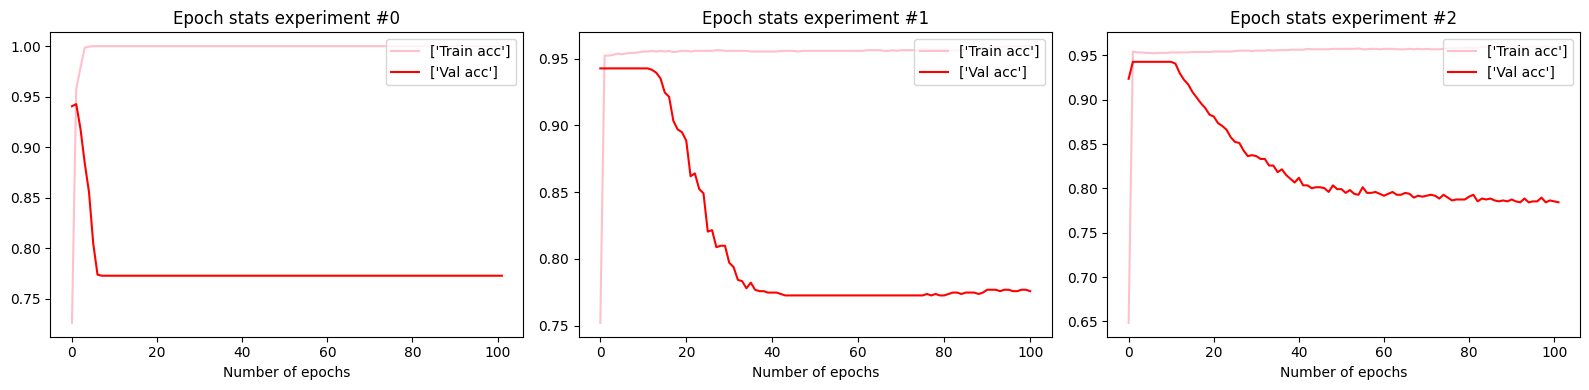

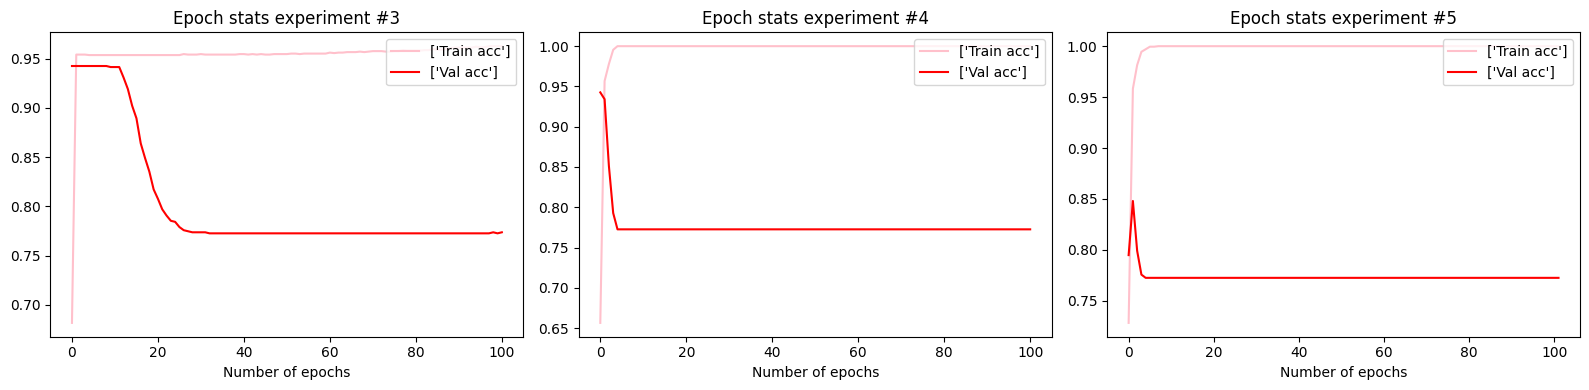

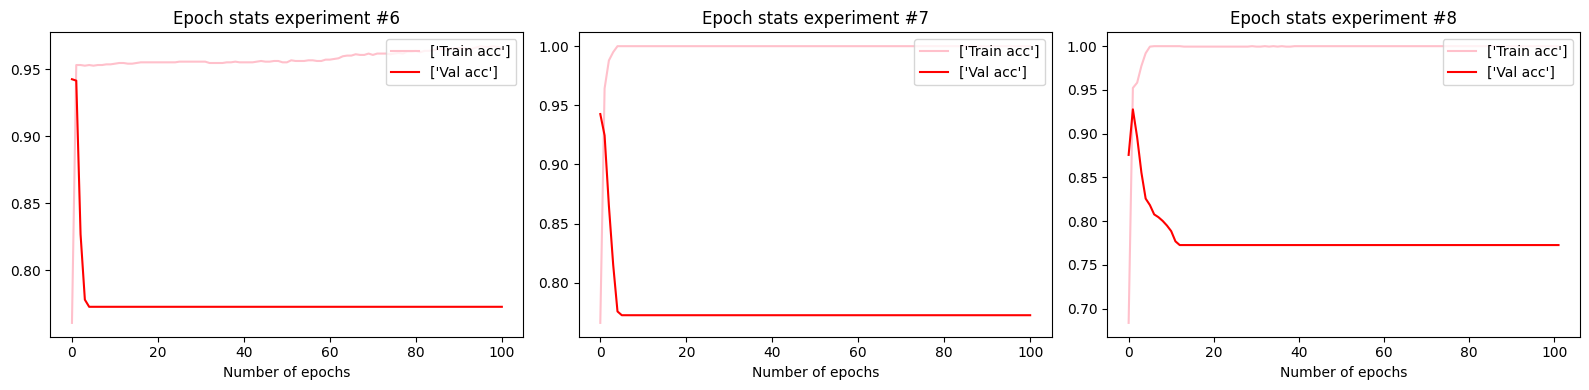

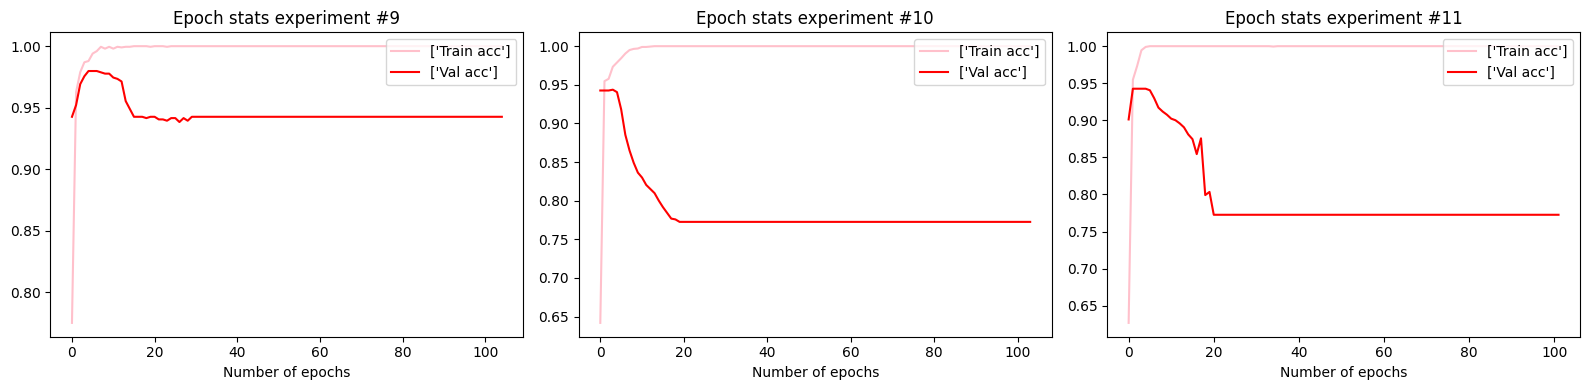

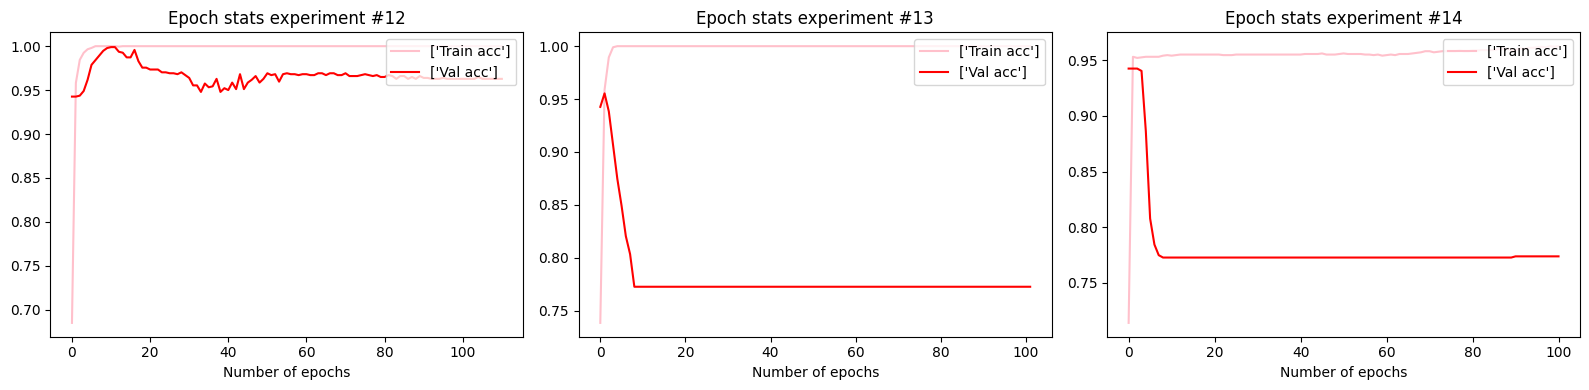

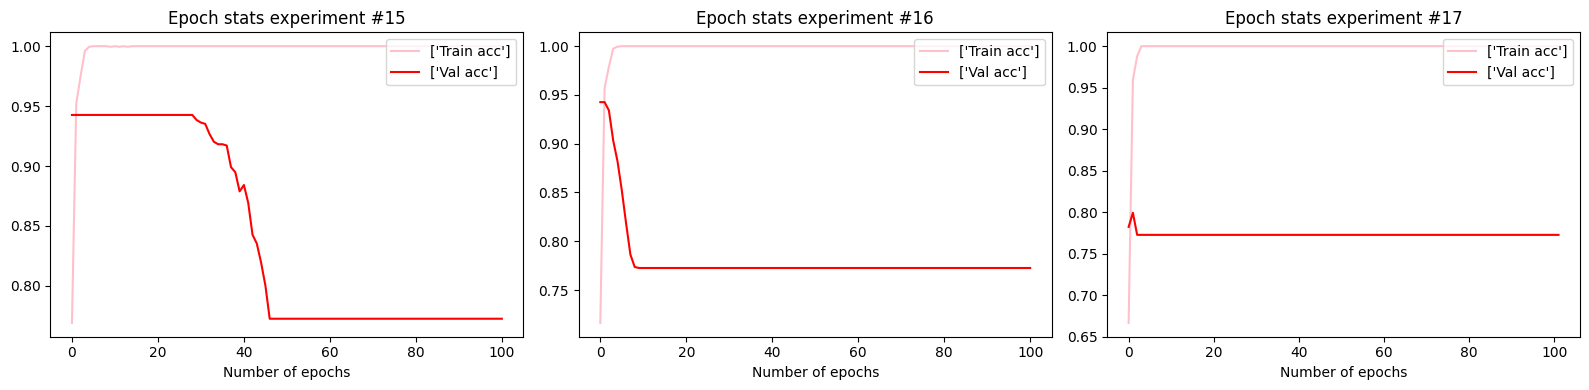

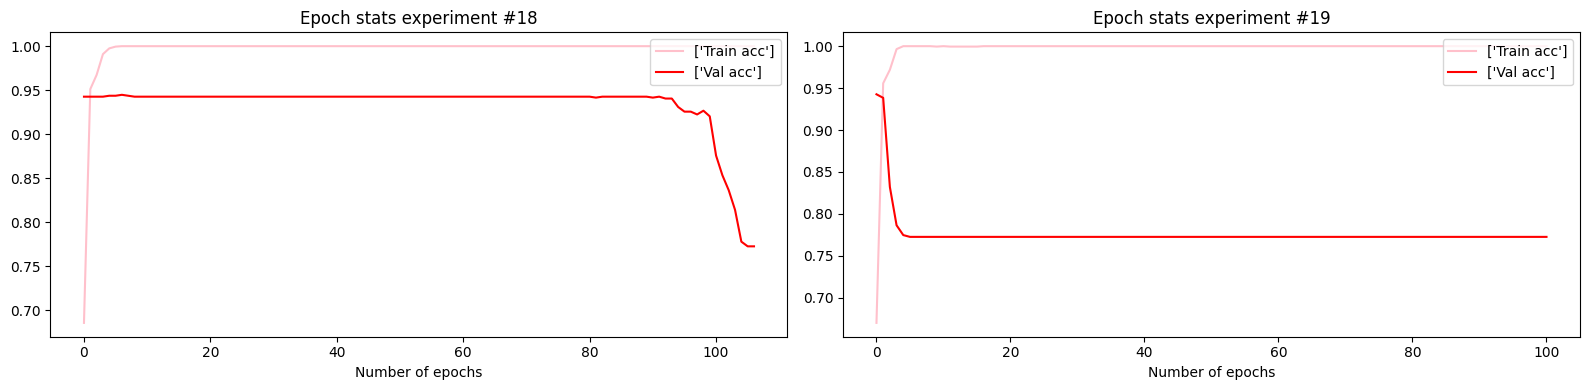

In [33]:
display_epochs_stats(cnn_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### LSTM

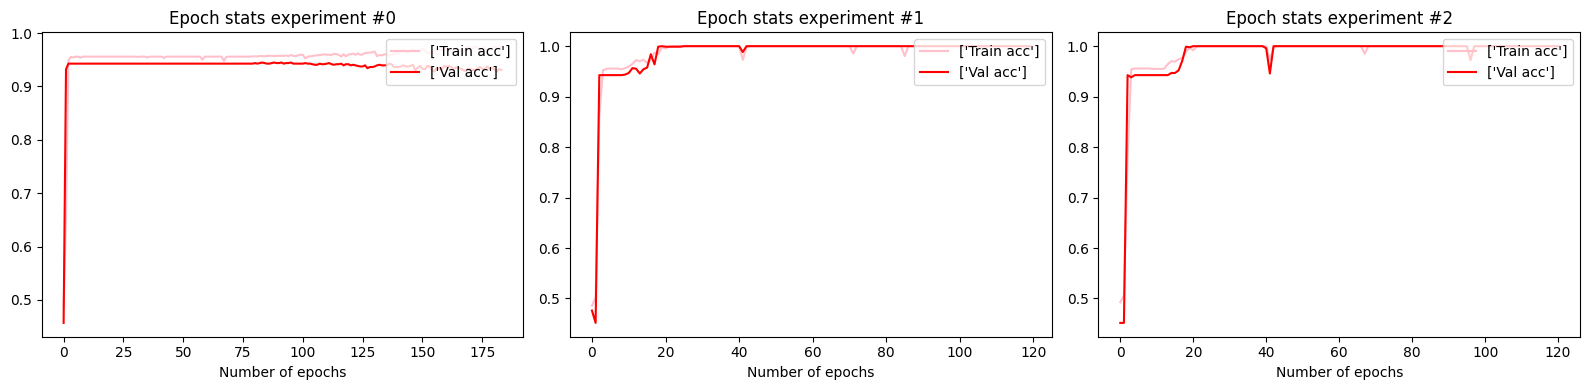

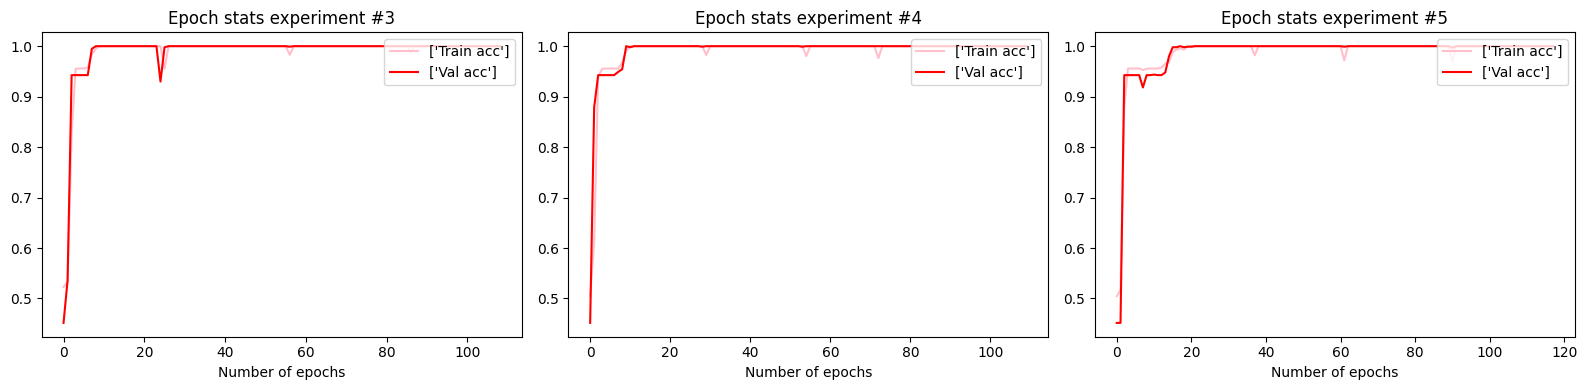

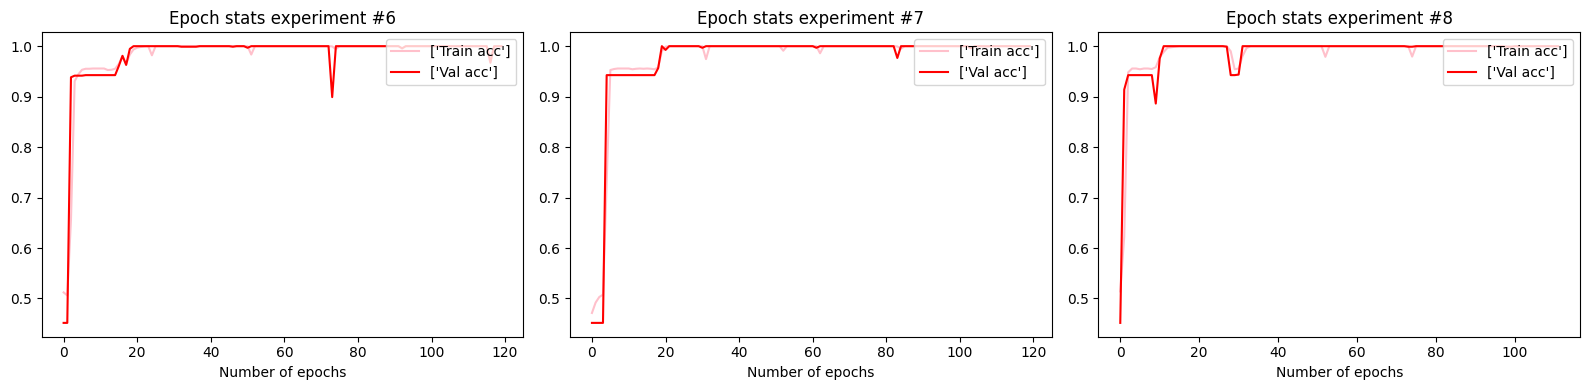

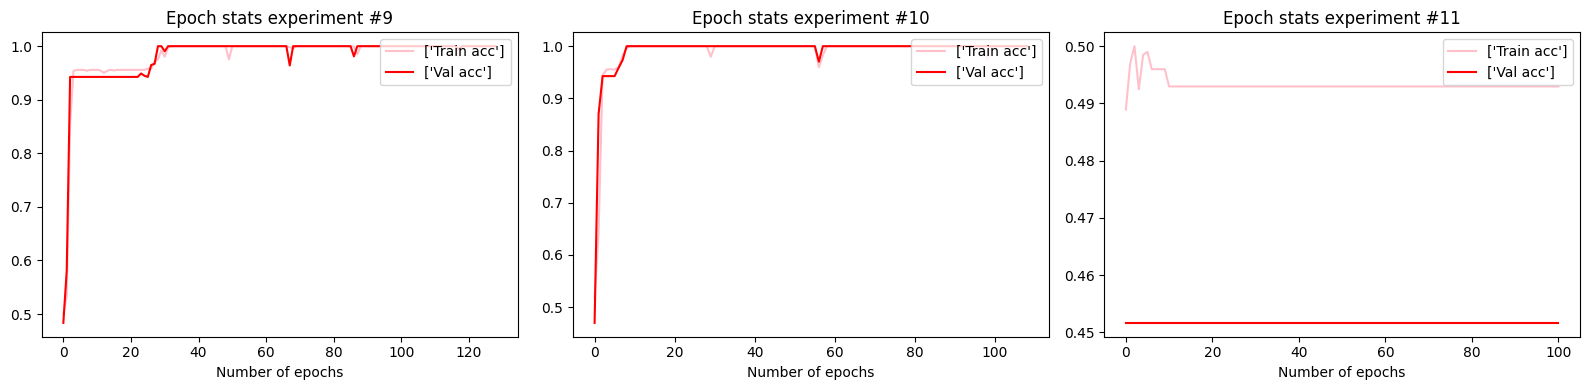

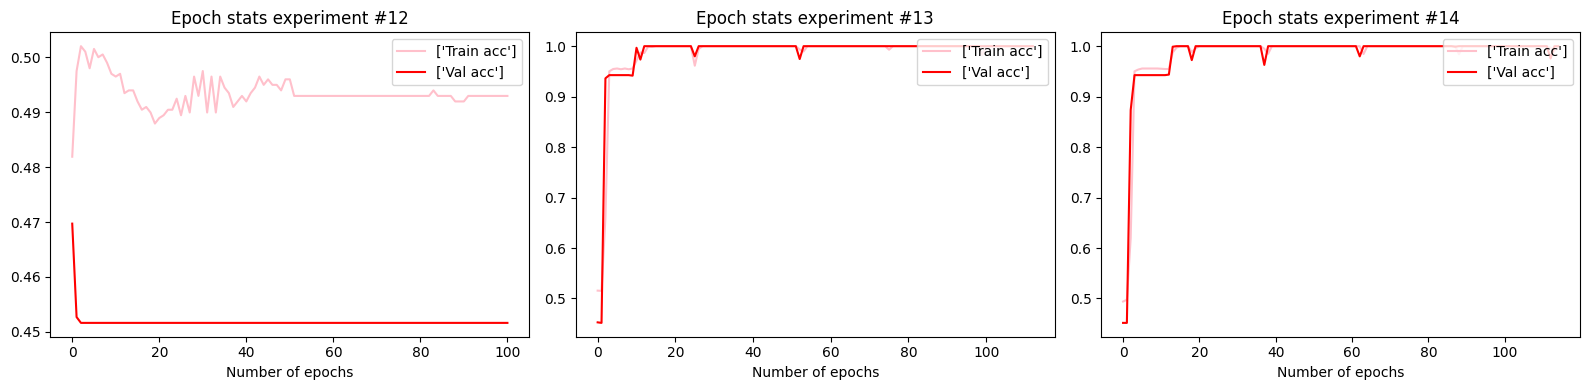

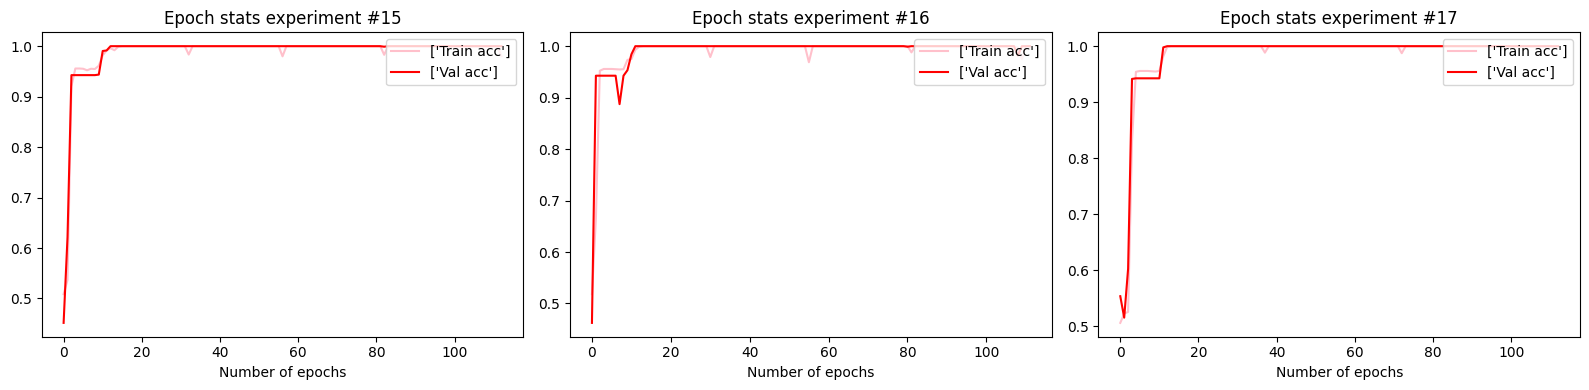

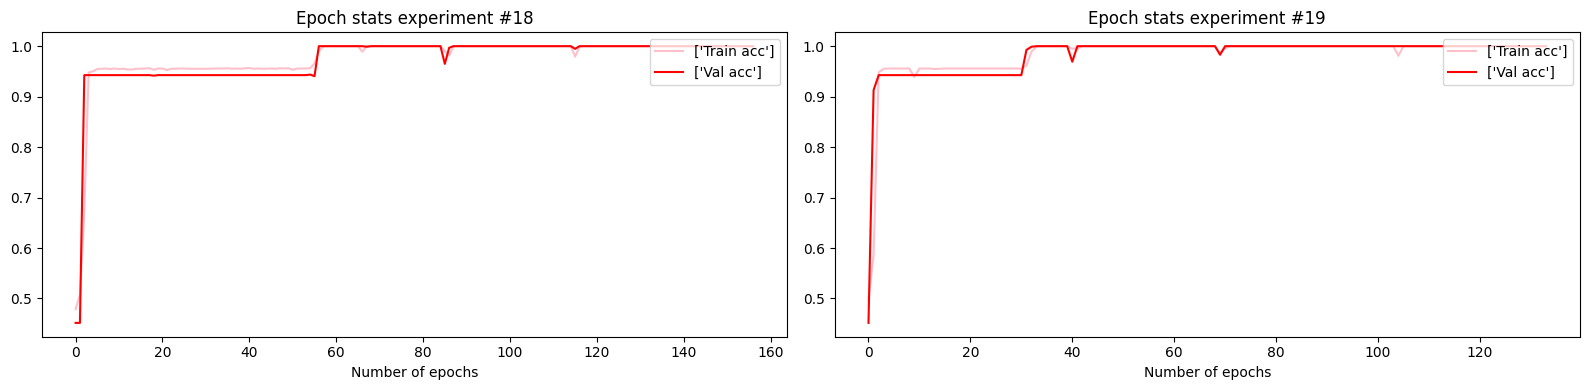

In [34]:
display_epochs_stats(lstm_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V1

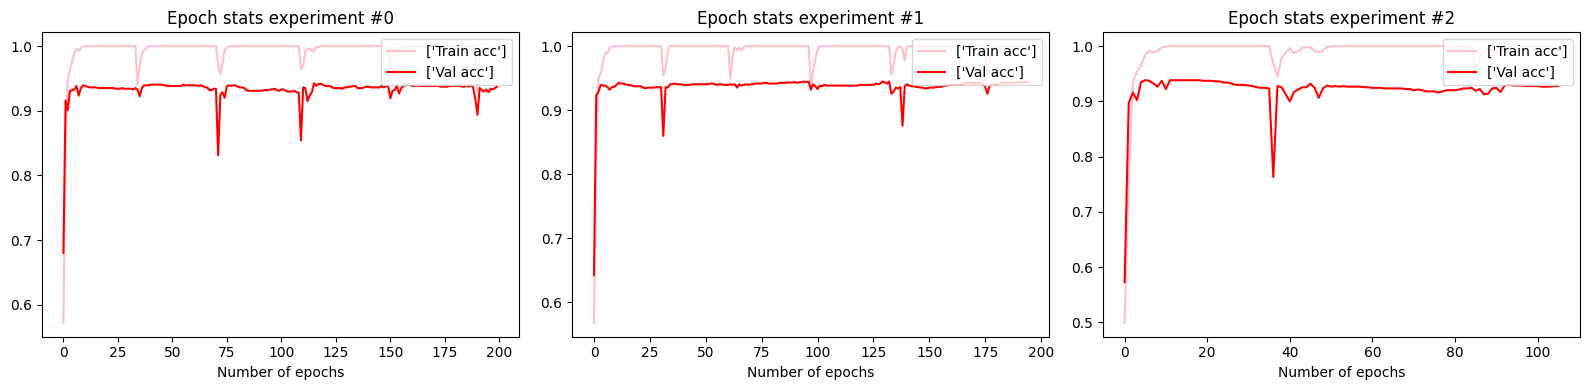

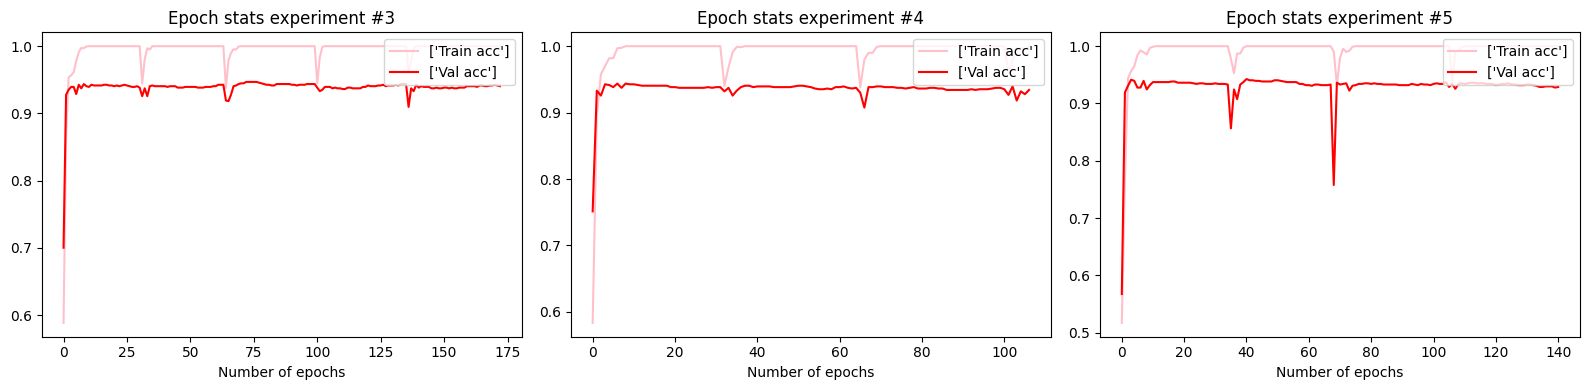

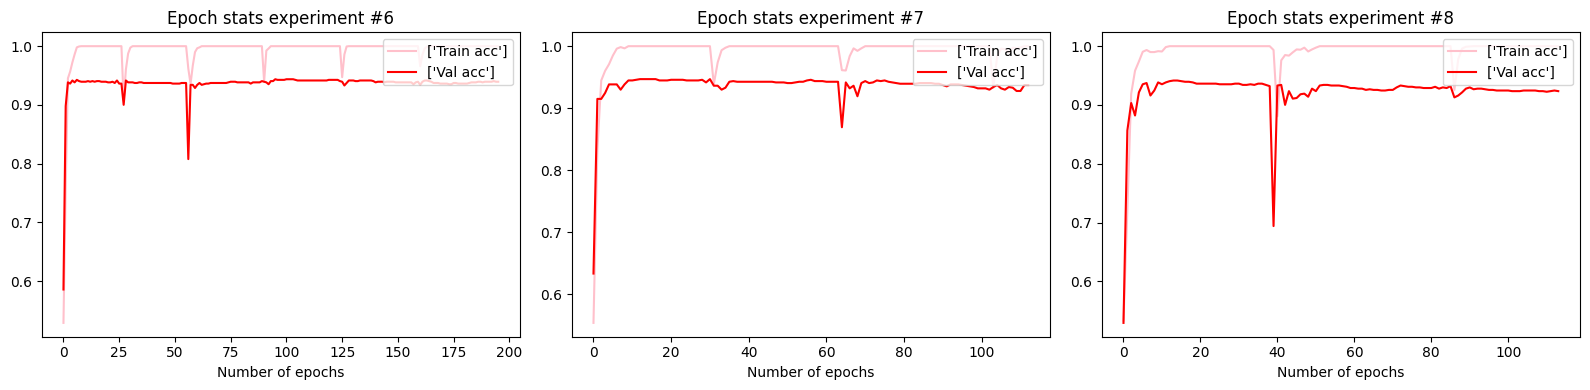

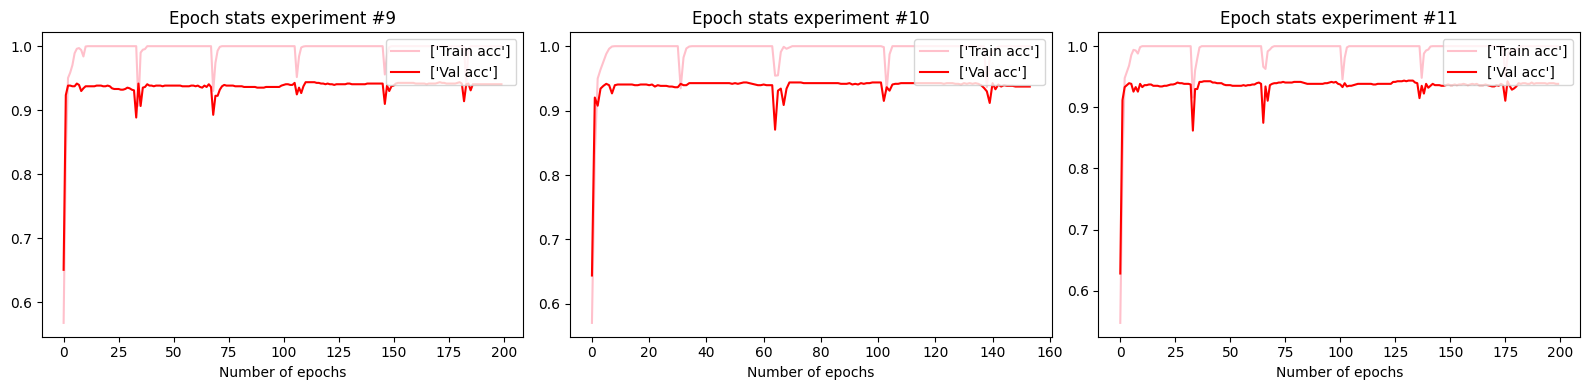

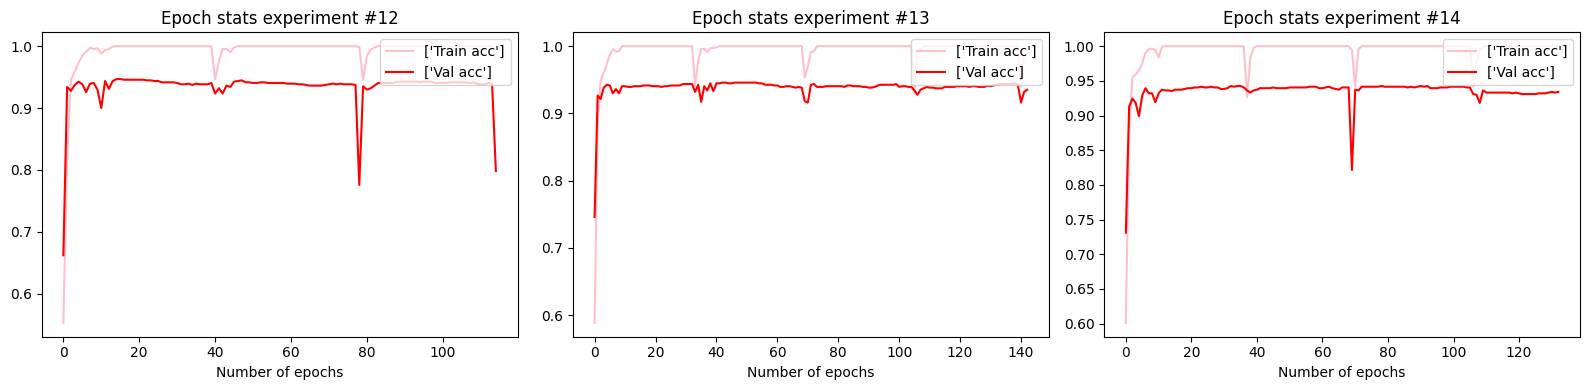

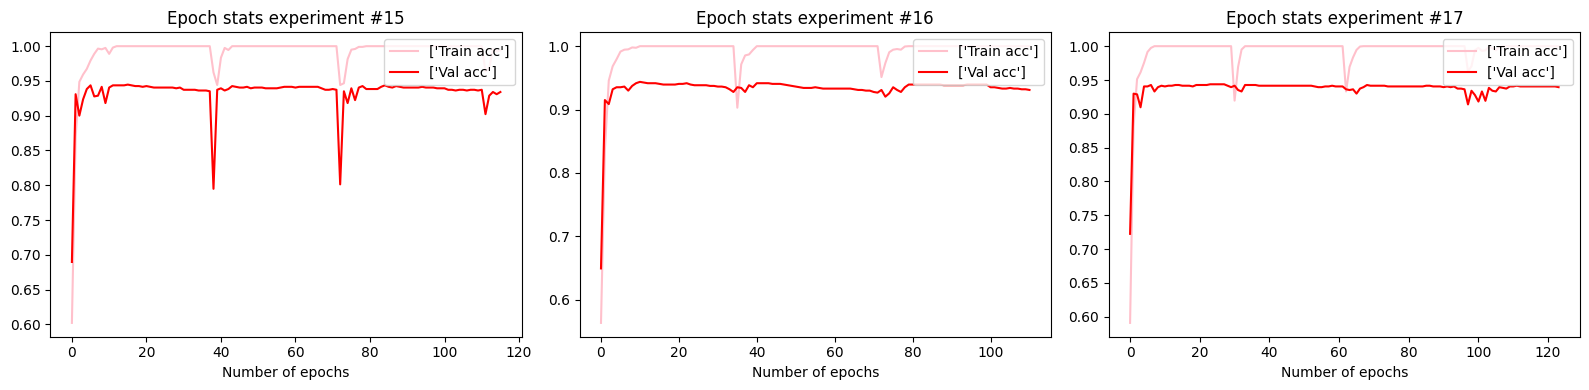

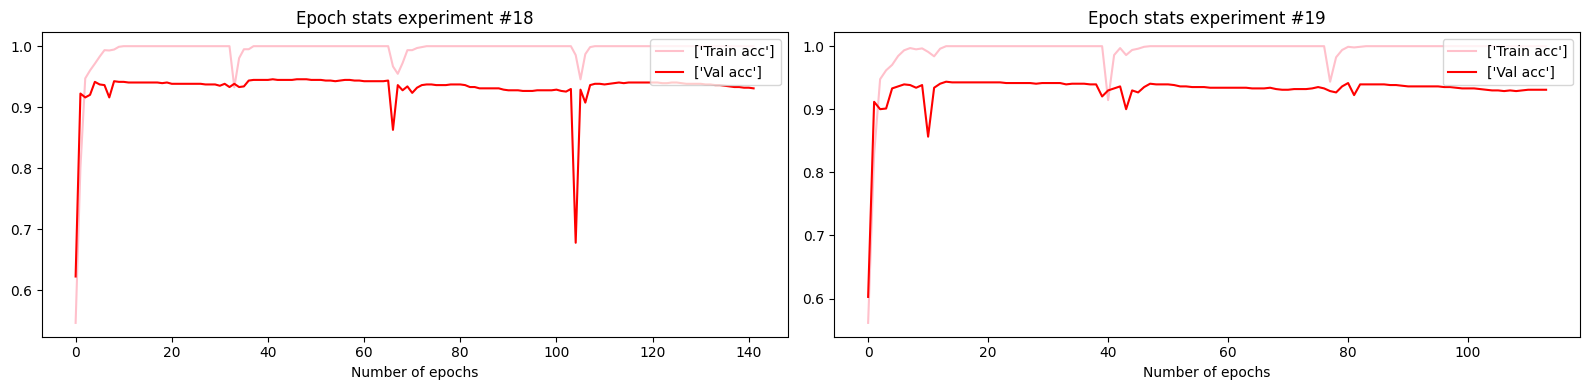

In [35]:
display_epochs_stats(deepset_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V2

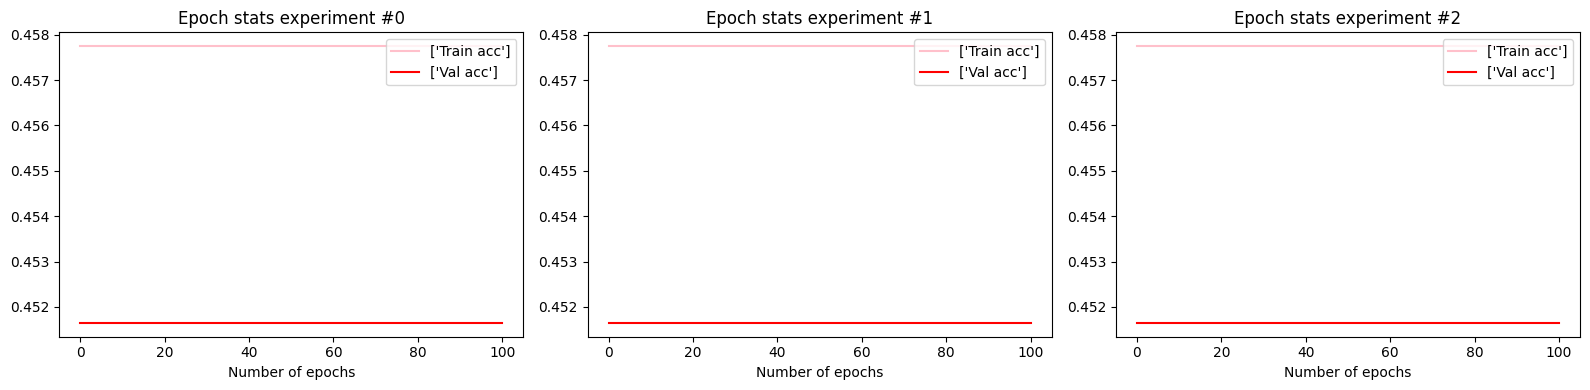

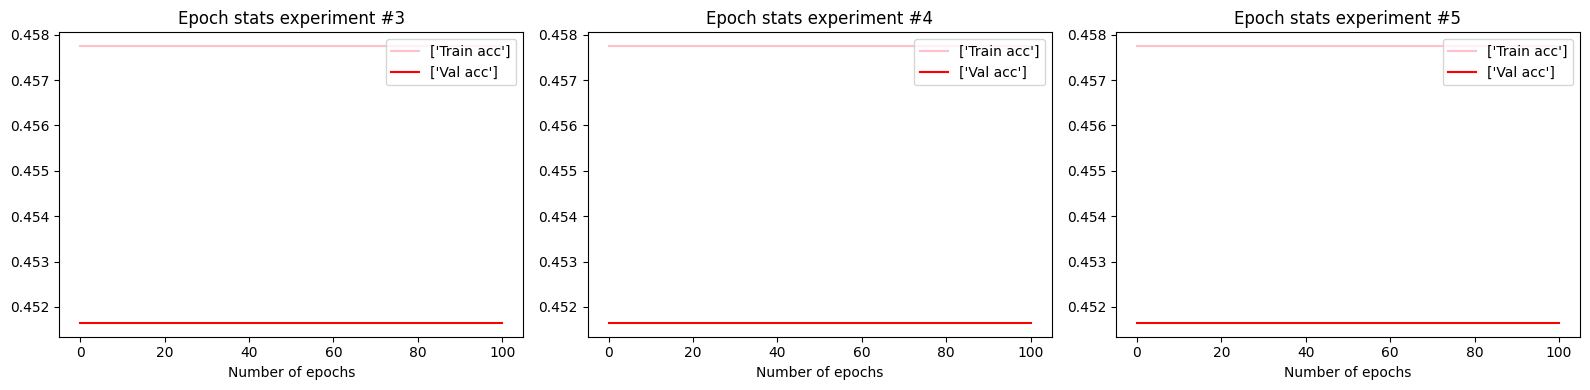

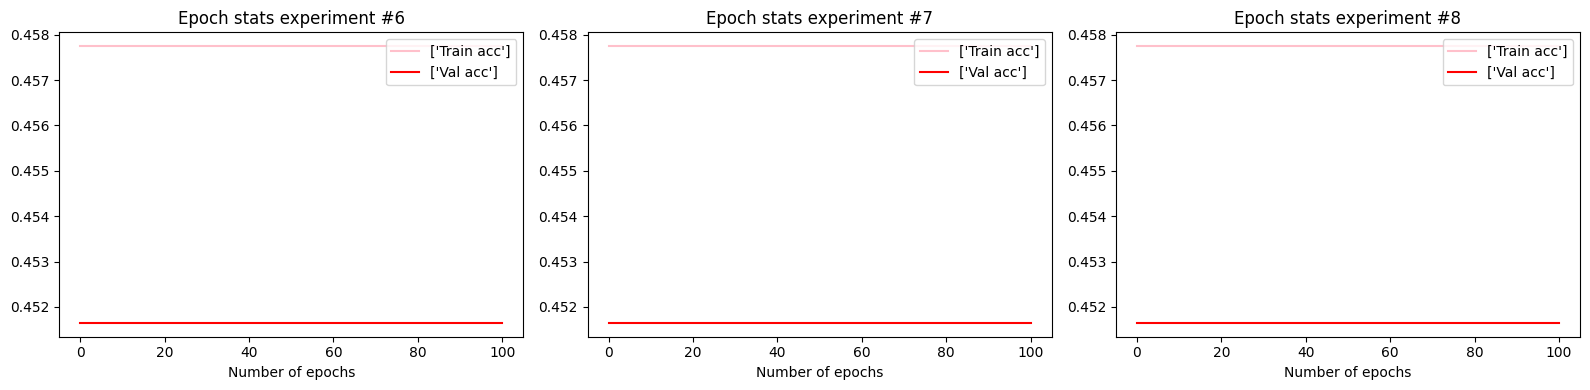

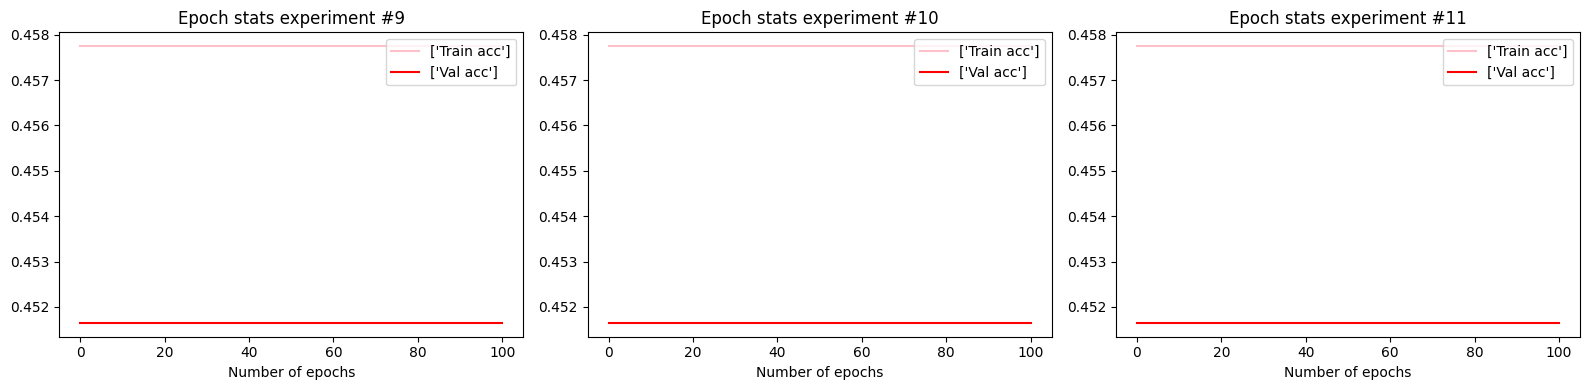

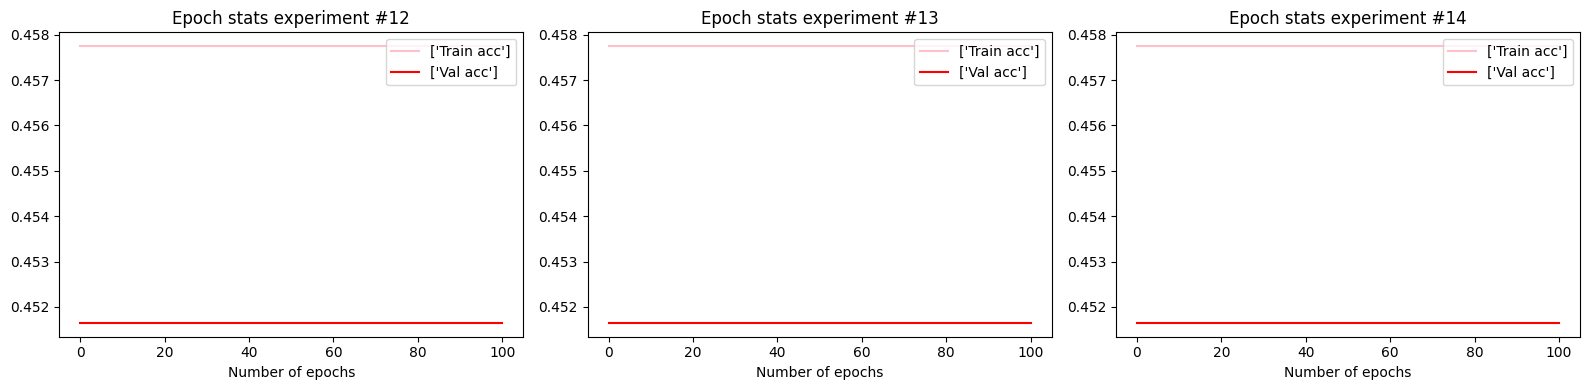

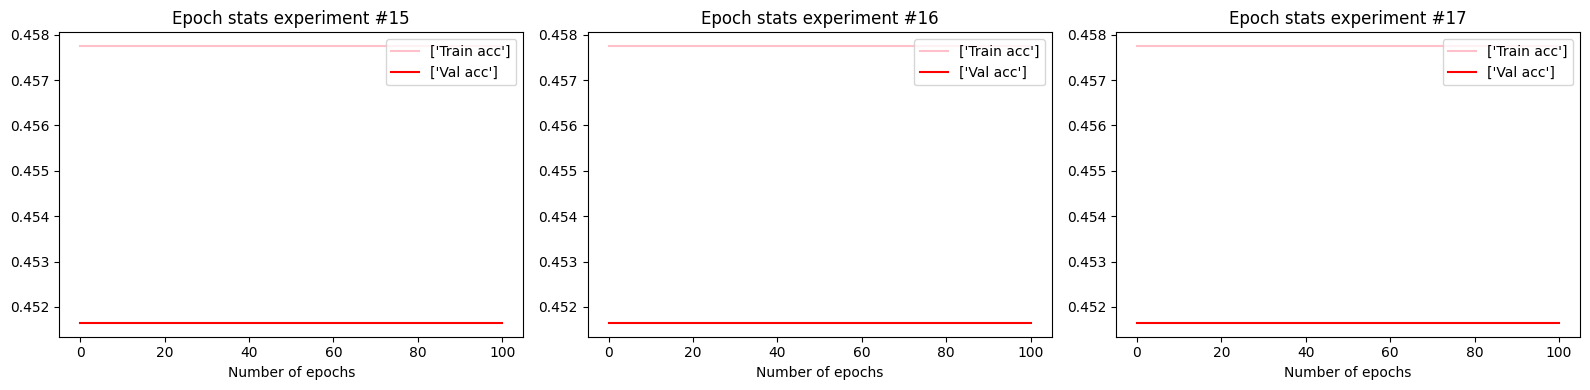

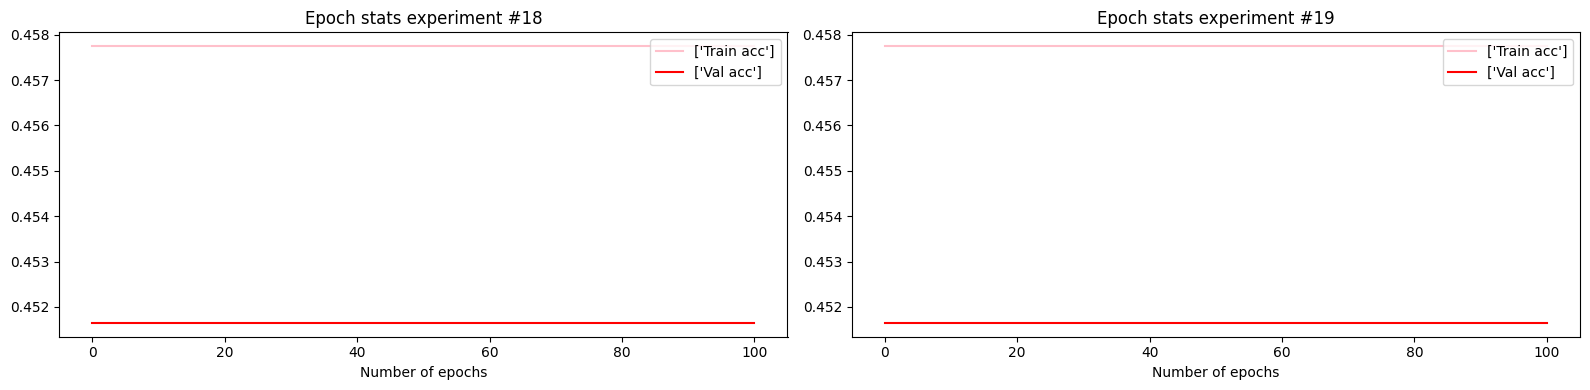

In [36]:
display_epochs_stats(deepsetv2_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### FeedForward

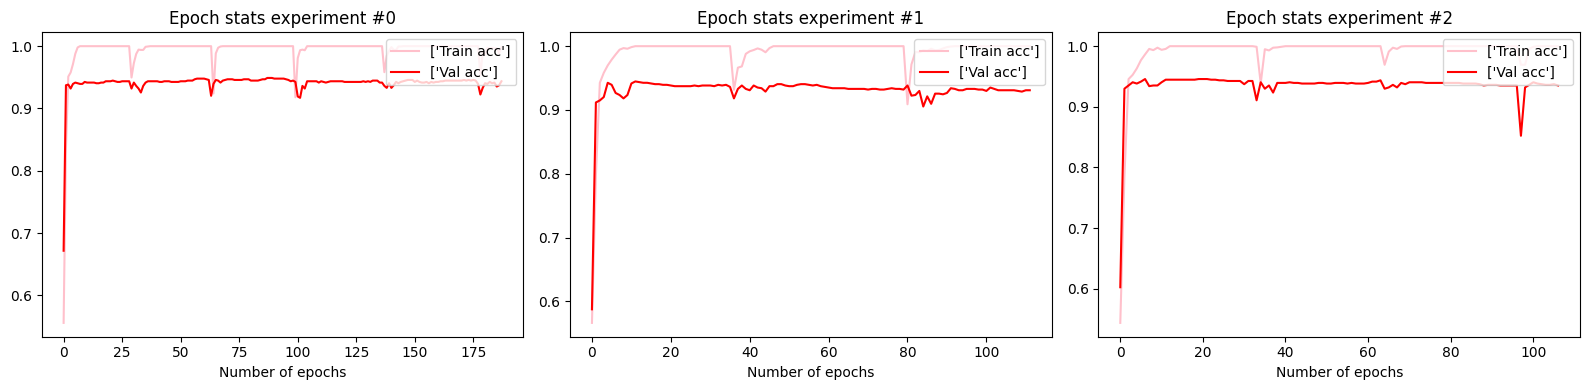

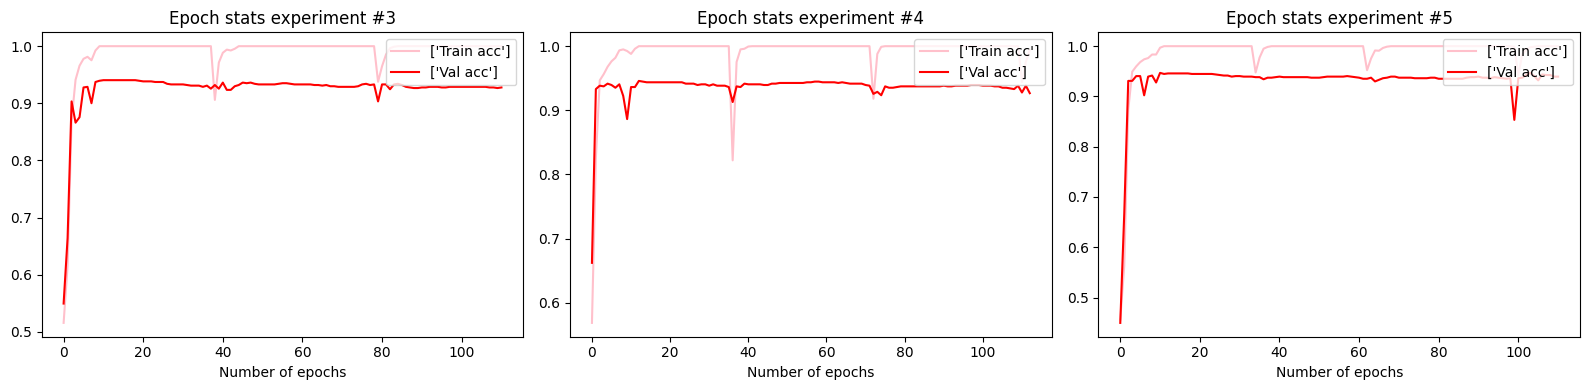

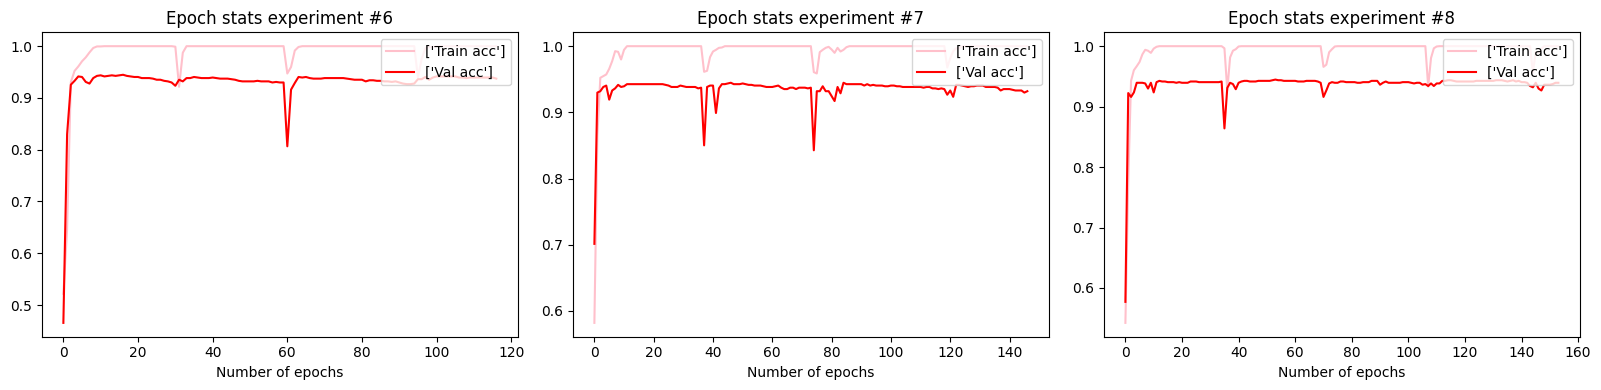

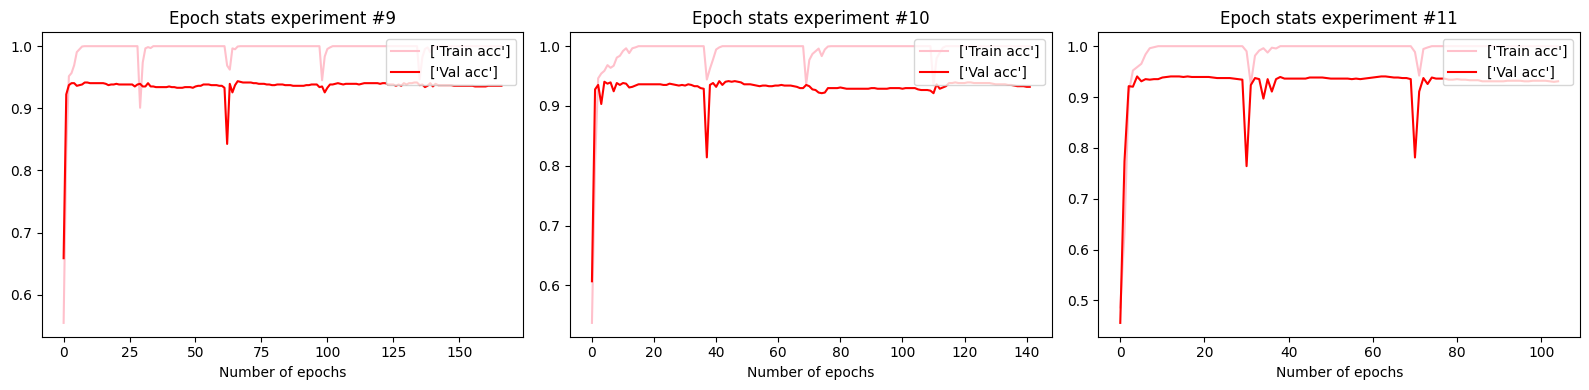

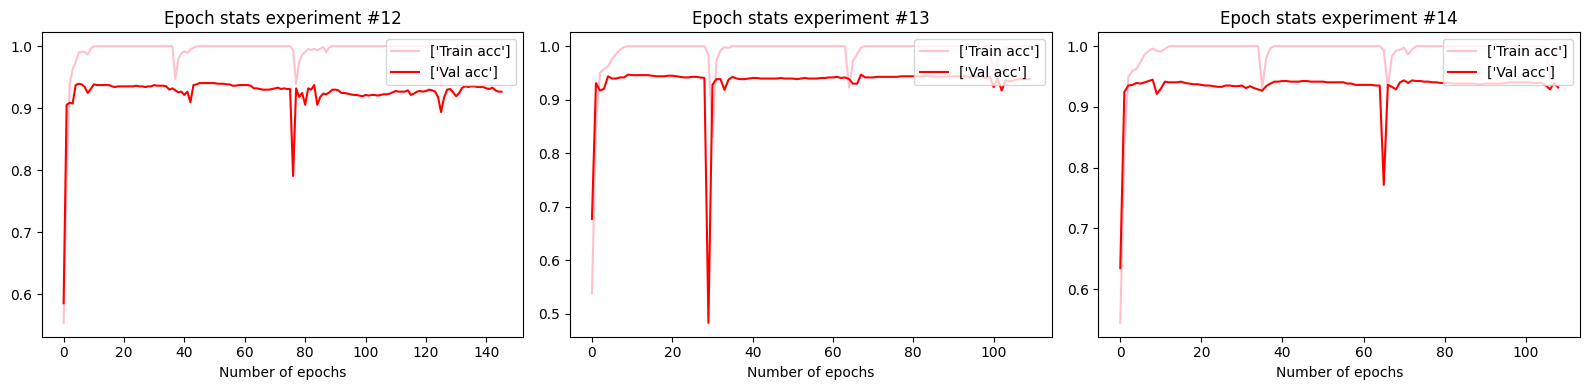

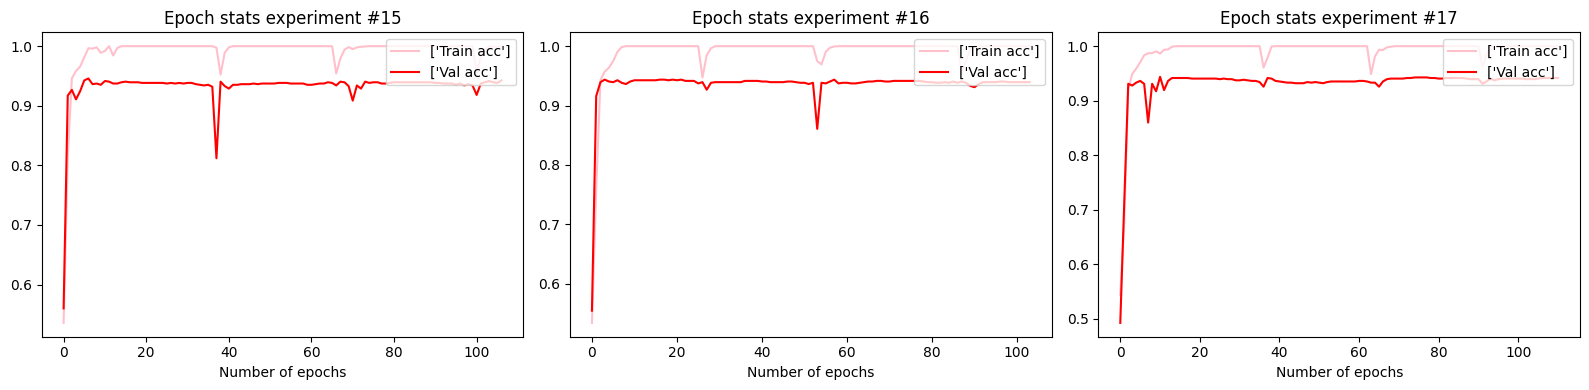

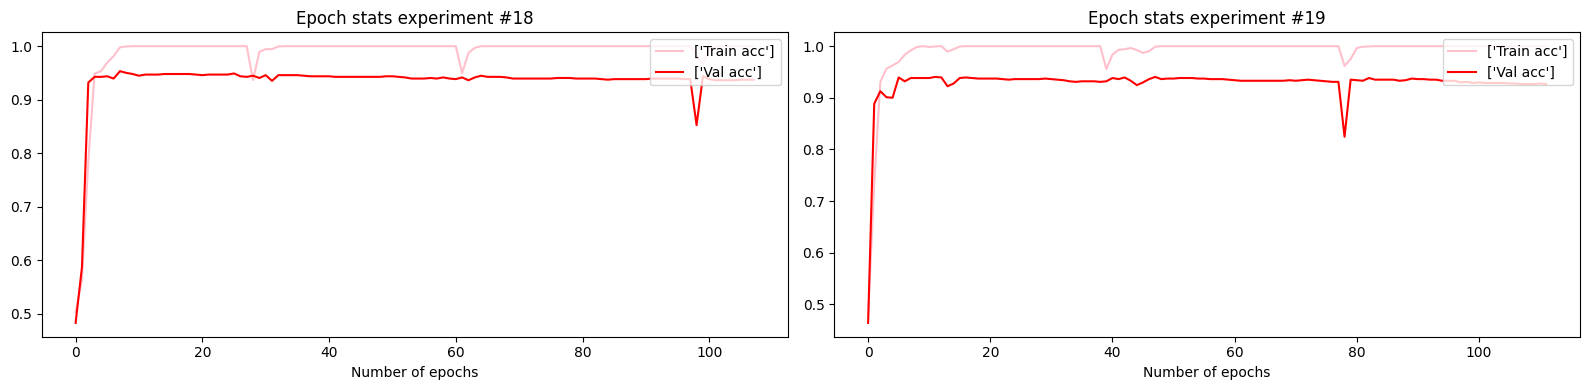

In [37]:
display_epochs_stats(feedforward_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

# Best performing models

In [7]:
best_lstm_model = LSTM_Model(data, 16, 32, 8).to(device)
best_lstm_model.load_state_dict(torch.load('./bestmodels/best_LSTM_model_' + experiment_name))
best_cnn_model = CNN_Model(data, 32, 64, 4, -1,).to(device)
best_cnn_model.load_state_dict(torch.load('./bestmodels/best_CNN_model_' + experiment_name))
best_deepset_model = DEEPSET_Model(data).to(device)
best_deepset_model.load_state_dict(torch.load('./bestmodels/best_DEEPSET_model_' + experiment_name))
best_deepsetv2_model = DEEPSETV2_Model(data).to(device)
best_deepsetv2_model.load_state_dict(torch.load('./bestmodels/best_DEEPSETV2_model_' + experiment_name))
best_feedforward_model = FEEDFORWARD_Model(data).to(device)
best_feedforward_model.load_state_dict(torch.load('./bestmodels/best_FEEDFORWARD_model_' + experiment_name))

<All keys matched successfully>

## Top wrong predictions for best performing CNN model

In [39]:
print_wrong_preds([get_wrong_predictions(best_cnn_model, x_test_cnn, y_test, test_original)], top_k=10)

Top 10 false positives: 

_,_,_._,,_,_,w.u _...,,,.__d_r.._ | label: False | actual prediction: 0.6786854863166809
...,._,.._,,_w_u ._d.r,.,__,_.,,, | label: False | actual prediction: 0.66073077917099

Top 10 false negatives: 

,_._,.__.,u_w.,, _,..___,,__._d.r | label: True | actual prediction: 0.4311605393886566
..__u,w.__.,,,._ ,.__._,,.,_,,d,r | label: True | actual prediction: 0.4407830238342285
.,__u_w_,_,,..__ _...,,.___.,d,r_ | label: True | actual prediction: 0.4708697199821472
._,_,u,w.....,__ .,__.,,,_.,,_d,r | label: True | actual prediction: 0.5253888964653015
.._.,,,.u_w_,._. _.___._,,d_r._,. | label: True | actual prediction: 0.5808455944061279
__.,,,u.w.__,.._ ,._.,,___,,_,d.r | label: True | actual prediction: 0.5853449702262878
,,,.._._.,.u,w._ .,,.__._._.,.d,r | label: True | actual prediction: 0.5864608287811279
.u,w_,.,_,.,.,_, ,,_._.__,_,,_d.r | label: True | actual prediction: 0.6037370562553406
.._,.u.w__._,,_, d,r_.,,,,.._._,_ | label: True | actual prediction

## Top wrong predictions for best performing LSTM model

In [40]:
print_wrong_preds([get_wrong_predictions(best_lstm_model, x_test_lstm, y_test, test_original)], top_k=10)

Top 10 false positives: 


Top 10 false negatives: 





## Top wrong predictions for best performing DeepSets V1 model

In [41]:
print_wrong_preds([get_wrong_predictions(best_deepset_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

_..,,_w,u,._..., __._,,_,_.d,r,__ | label: False | actual prediction: 0.9999841451644897
...,,,__.w_u__,, _d.r,,_....,.,_. | label: False | actual prediction: 0.9999785423278809
._.,_.,,_w.u,,._ _,,__,..,d.r..._ | label: False | actual prediction: 0.9999773502349854
_...__._w.u_.__, ,_d,r_.__,,__.__ | label: False | actual prediction: 0.9999762773513794
,___.._,w_u_..,. d.r__,__.._,,,,_ | label: False | actual prediction: 0.9999719858169556
w_u.,_._...,,,., d,r_.,,,,_._,___ | label: False | actual prediction: 0.9999681711196899
.__,__._w.u,.,_. ,.,_,,,._d.r..__ | label: False | actual prediction: 0.9999572038650513
.___w_u.____._., d_r,.,,__.._____ | label: False | actual prediction: 0.9999488592147827
,,_,_.w,u,.,_,._ ,.,_,d_r...__,_, | label: False | actual prediction: 0.9999473094940186
,,.,,,..w.u..,._ .d.r,..,.,_.,.., | label: False | actual prediction: 0.9999467134475708

Top 10 false negatives: 

,,...w.u_..,__,. ._,.,_.,.r.._.,, | label: True | actual 

## Top wrong predictions for best performing DeepSets V2 model

In [42]:
print_wrong_preds([get_wrong_predictions(best_deepsetv2_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 


Top 10 false negatives: 

..,,_,__,.,u.w,. _.___,_d.r.._,,. | label: True | actual prediction: 0.5
__._..__._..__._ __._,..__r,_.,_. | label: True | actual prediction: 0.5
_..u,w,,_.,____, ..,,,,_d,r,_.._. | label: True | actual prediction: 0.5
..___._.,.u_w.., _..__,_,,,__r_.. | label: True | actual prediction: 0.5
w.__,._._.____.. __,,.,_,r....... | label: True | actual prediction: 0.5
___,,..,,___.,__ ,_,_,r.,.,__.... | label: True | actual prediction: 0.5
_,.__,,,,u,w,__. _,__.r._._.___,_ | label: True | actual prediction: 0.5
._,__,...w,,,_,_ .,._d,r,,__,,.._ | label: True | actual prediction: 0.5
..,,.u,w_,.,,.__ .,.__,,r...,.,_. | label: True | actual prediction: 0.5
u_w._,,,____,_.. _r____.,.,,.,.,_ | label: True | actual prediction: 0.5




## Top wrong predictions for best performing Feedforward model

In [43]:
print_wrong_preds([get_wrong_predictions(best_feedforward_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

w,u,,.,.,_.__.,. ___._d.r__..,,,, | label: False | actual prediction: 0.9999793767929077
w_u_..,__,._,,,. ,_.,,__,_,,._d_r | label: False | actual prediction: 0.9999686479568481
,,___.,,w_u,,.,_ _,,.,_..d_r_._._ | label: False | actual prediction: 0.999966025352478
.___,,,_w.u,,... .,,,,__,.,,._d,r | label: False | actual prediction: 0.9999501705169678
._.__w_u...,_,,, ,,.d.r,_._..,.., | label: False | actual prediction: 0.9999421834945679
_,.,.._,.,,,,w.u ,__d_r,.._,_,,__ | label: False | actual prediction: 0.99993896484375
,___.._,w_u_..,. d.r__,__.._,,,,_ | label: False | actual prediction: 0.9999384880065918
_,__w.u._.,,_.,_ ,d,r__.,_,,__.__ | label: False | actual prediction: 0.9999374151229858
_.._w,u,_.___.,, __...,.,,.,d.r,, | label: False | actual prediction: 0.9999361038208008
,_._w,u,,..,,_,_ ,,_,,__,,.,_,d_r | label: False | actual prediction: 0.9999251365661621

Top 10 false negatives: 

,._.....__,.w_u_ .,,,...r,.,.._,. | label: True | actual pre

# Saving Notebook State

In [44]:
import dill
dill.dump_session('notebook_env_' + experiment_name + '.db')

ModuleNotFoundError: No module named 'dill'

# Loading Notebook State

In [ ]:
import dill
experiment_name = "interop_1"
# dill.load_session('notebook_env_' + experiment_name + '.db')

In [14]:
import shap

ImportError: Numba needs NumPy 2.1 or less. Got NumPy 2.2.

In [9]:
def explain_with_kernelshap(model, x_train, x_test, num_samples=100, num_explain=10):
    """
    Aplica Kernel SHAP al modelo entrenado y visualiza los valores SHAP.
    
    Parámetros:
        model: Modelo de PyTorch ya entrenado.
        x_train: Datos de entrenamiento (usados como referencia para SHAP).
        x_test: Datos de prueba sobre los que se explicarán las predicciones.
        num_samples: Número de muestras de entrenamiento usadas como referencia para SHAP.
        num_explain: Número de muestras de prueba que serán explicadas.
    """
    model.eval()  # Cambiar a modo evaluación

    # Función de predicción para SHAP (con softmax para probabilidades)
    def model_predict(inputs):
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        with torch.no_grad():
            outputs = model(inputs)
            return F.softmax(outputs, dim=1).cpu().numpy()  # Convertir logits a probabilidades

    # Seleccionar una muestra de entrenamiento como referencia para SHAP
    x_sample = x_train[:num_samples]

    # Crear el explicador de SHAP con KernelExplainer
    explainer = shap.KernelExplainer(model_predict, x_sample)

    # Obtener valores SHAP para un subconjunto de los datos de prueba
    shap_values = explainer.shap_values(x_test[:num_explain])

    # Visualizar los valores SHAP
    shap.summary_plot(shap_values, x_test[:num_explain])


# ===========================
# APLICAR KERNEL SHAP AL MODELO ENTRENADO
# ===========================
explain_with_kernelshap(best_lstm_model, x_train, x_test)

NameError: name 'shap' is not defined